### Analyse Exploratoire des Données - `1_exploration.ipynb`

#### Objectif :
Effectuer une première analyse exploratoire des données pour comprendre la répartition des classes, les distributions de texte, et d’autres caractéristiques pertinentes.

#### 1. Chargement des Données

L’objectif de cette étape est d’importer les données brutes et de vérifier leur structure générale pour en déduire les premières observations.

In [19]:
# Import des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importer les fonctions nécessaires depuis le package src
from src import load_data, clean_text

# Charger les données brutes
df = load_data('../data/tweets_suspect.csv')

# Appliquer le nettoyage du texte
df['cleaned_tweet'] = df['tweet'].apply(clean_text)

# Afficher les premières lignes pour vérifier
df.head()


ModuleNotFoundError: No module named 'src'

Ici, nous chargeons le fichier CSV `tweets_suspect.csv` pour voir un aperçu des premières lignes. Cela nous aide à comprendre la structure de chaque colonne et le type de contenu qu'elle contient.

#### 2. Aperçu des Données

Dans cette étape, on examine les informations de base sur le DataFrame, comme le nombre de lignes, les noms des colonnes, et le type de données.

In [14]:
df.rename(columns={'message': 'tweet'}, inplace=True)

# Informations générales sur les données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet         60000 non-null  object
 1   label         60000 non-null  int64 
 2   tweet_length  60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


- Cette commande nous fournit des informations essentielles comme le type de chaque colonne (numérique, objet, etc.), le nombre de valeurs non nulles, et la mémoire utilisée par le DataFrame.

#### 3. Résumé Statistique des Colonnes Numériques

Si notre dataset contient des colonnes numériques (par exemple, une colonne indiquant le nombre de retweets ou de likes), nous calculons des statistiques descriptives pour mieux comprendre leur distribution.

In [3]:
# Statistiques descriptives
df.describe()

,label
count,60000.000000
mean,0.897583
std,0.303198
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


Ce tableau présente des statistiques telles que la moyenne, l’écart type, le minimum et le maximum pour chaque colonne numérique.

### 4. Vérification des Valeurs Manquantes

Il est important d’identifier les valeurs manquantes pour décider de la meilleure approche de nettoyage.

In [4]:
# Comptage des valeurs manquantes
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

Cela permet de visualiser rapidement quelles colonnes contiennent des valeurs manquantes. Si des valeurs manquantes sont trouvées, nous pouvons décider de les supprimer ou de les imputer.

### 5. Exploration des Classes de Cible (si applicable)

Dans le contexte de détection de tweets suspects, il est probable que notre dataset contienne une colonne cible indiquant si un tweet est suspect ou non. Il est essentiel d’examiner la distribution des classes pour vérifier si le dataset est équilibré.

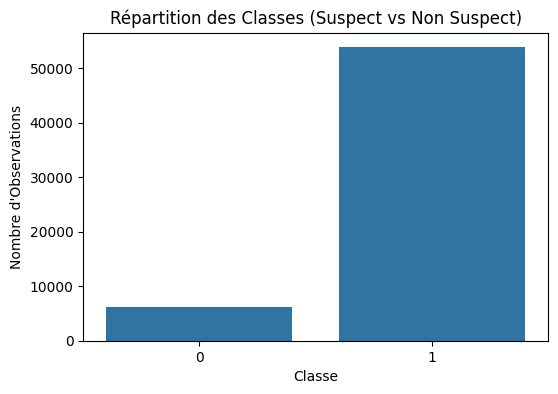

In [5]:
# Distribution des classes cible
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)  # Remplacez 'label' par le nom de la colonne cible
plt.title("Répartition des Classes (Suspect vs Non Suspect)")
plt.xlabel("Classe")
plt.ylabel("Nombre d'Observations")
plt.show()

Si les classes sont déséquilibrées, cela pourrait affecter la performance du modèle, et des techniques de gestion des classes déséquilibrées seraient alors nécessaires.

### 6. Analyse Exploratoire Textuelle

Comme nous traitons des données textuelles, nous explorons maintenant les caractéristiques des textes eux-mêmes pour en extraire des informations préliminaires sur le contenu des tweets.

#### Longueur des Tweets

Analyser la longueur des tweets peut nous donner des indices sur les différences entre les tweets suspects et non suspects.

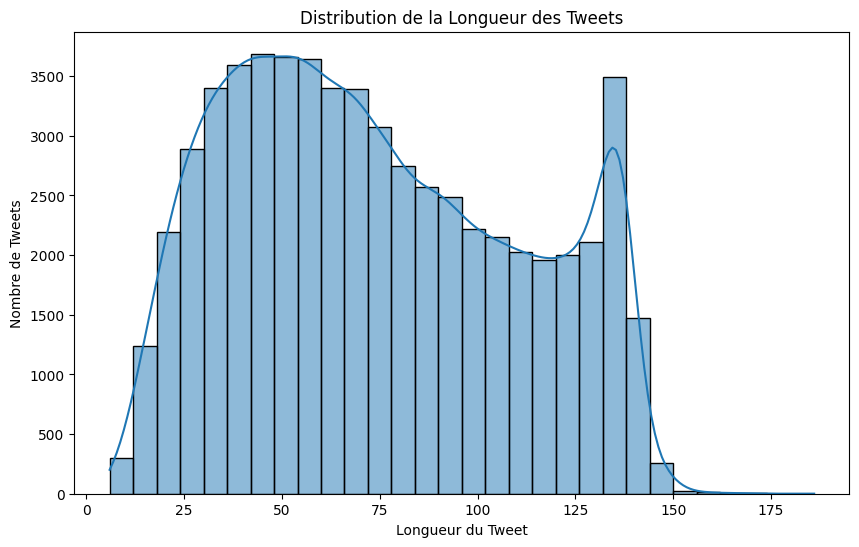

In [6]:
# Calcul de la longueur de chaque tweet
df['tweet_length'] = df['tweet'].apply(len)

# Visualisation de la distribution des longueurs de tweets
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], kde=True, bins=30)
plt.title("Distribution de la Longueur des Tweets")
plt.xlabel("Longueur du Tweet")
plt.ylabel("Nombre de Tweets")
plt.show()


#### Fréquence des Mots

Identifier les mots les plus fréquents peut également nous fournir des informations sur les sujets communs et le vocabulaire utilisé dans les tweets suspects.

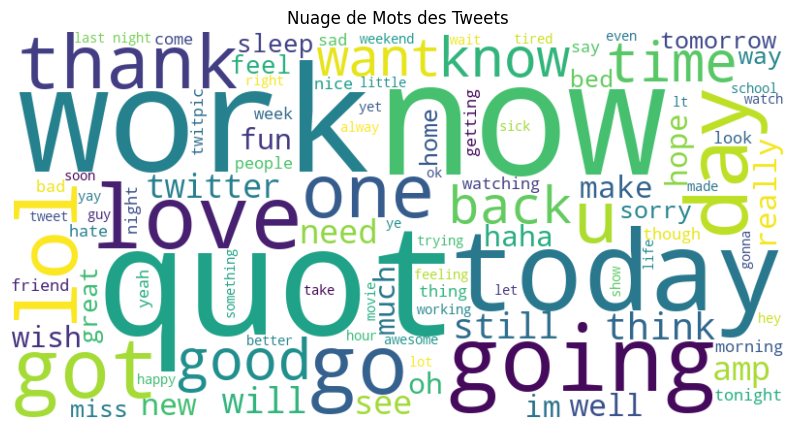

In [7]:
from collections import Counter
from wordcloud import WordCloud

# Concaténation de tous les tweets
all_words = ' '.join(df['tweet'])

# Nuage de mots
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de Mots des Tweets")
plt.show()


#### Analyse des Bigrammes et Trigrammes

Les bigrammes et trigrammes (séquences de deux ou trois mots) peuvent révéler des expressions fréquentes, potentiellement utiles pour identifier des modèles suspects dans le langage.

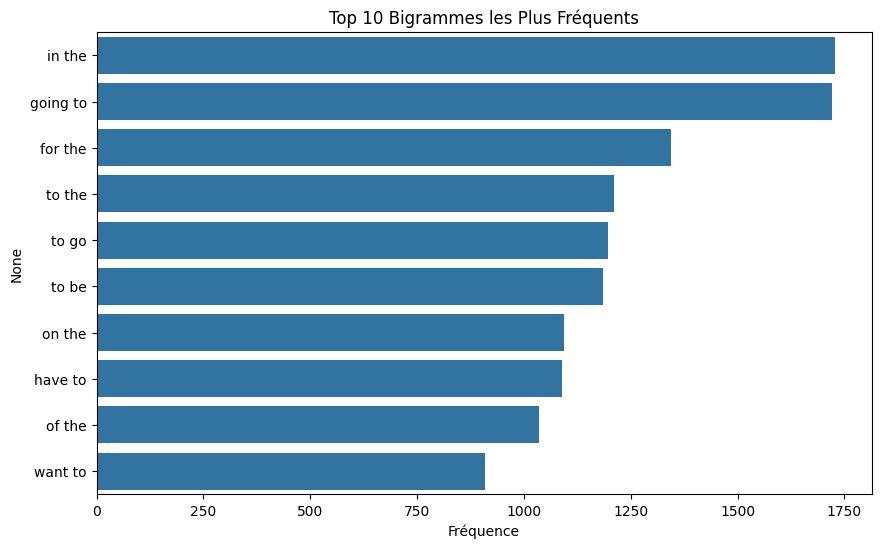

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Limiter le nombre de bigrammes analysés et transformer en représentation éparse
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=5000)
bigrams = vectorizer.fit_transform(df['tweet'])

# Création du DataFrame épars pour calculer les fréquences
bigram_freq = pd.DataFrame.sparse.from_spmatrix(bigrams, columns=vectorizer.get_feature_names_out())
top_bigrams = bigram_freq.sum().sort_values(ascending=False).head(10)

# Visualisation des bigrammes les plus fréquents
plt.figure(figsize=(10, 6))
sns.barplot(x=top_bigrams.values, y=top_bigrams.index)
plt.title("Top 10 Bigrammes les Plus Fréquents")
plt.xlabel("Fréquence")
plt.show()




### 7. Corrélation Entre les Variables (si pertinent)

Si le dataset contient des variables numériques supplémentaires, nous pourrions visualiser une matrice de corrélation pour identifier les relations potentielles entre elles.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Utilisation du TfidfVectorizer pour transformer les tweets en vecteurs
vectorizer = TfidfVectorizer(max_features=1000)  # Sélectionner un nombre limité de caractéristiques
X = vectorizer.fit_transform(df['tweet'])

# Convertir la matrice sparse en DataFrame
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Ajouter la colonne 'label' au DataFrame
X_df['label'] = df['label']

# Affichage de la forme du DataFrame
X_df.shape


(60000, 1001)

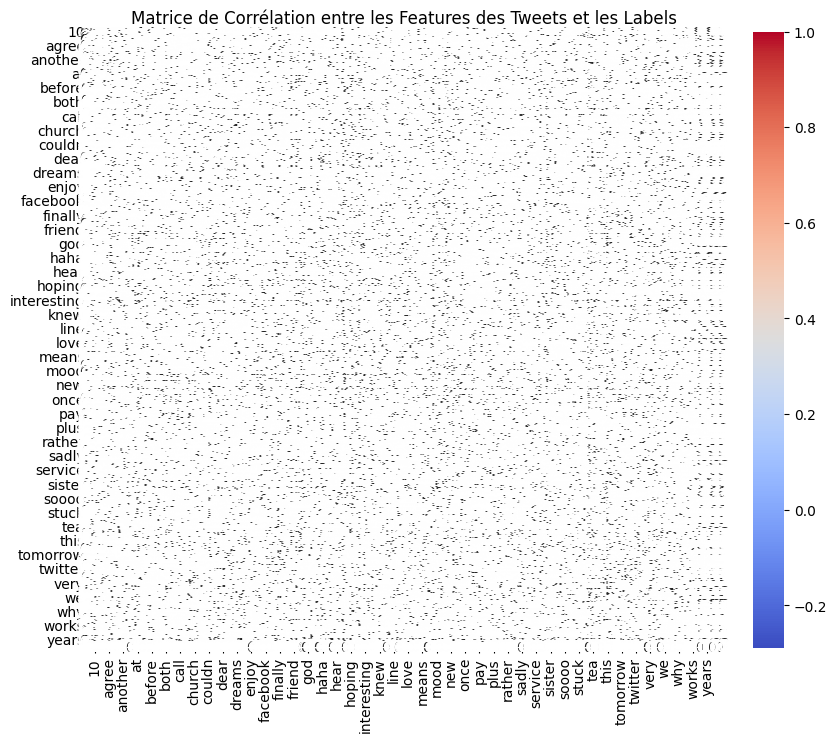

In [10]:
# Calcul de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(X_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation entre les Features des Tweets et les Labels")
plt.show()

### 8. Conclusion de l’Analyse Exploratoire

En terminant cette analyse, nous avons maintenant une bonne compréhension de la structure des données et des premiers éléments qui pourraient aider dans le processus de modélisation. Nous avons également identifié les besoins en nettoyage et en transformation pour le prétraitement des données.

In [ ]:
# Sauvegarder df dans un fichier pickle
df.to_pickle('..//data/df_data.pkl')


: 